In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/SMA_final/') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['SMA_FR_Graph.ipynb',
 'chiikawa_data',
 'dict',
 'SMA_final_classification.ipynb',
 'chiikawa_unified_data.csv',
 'copy',
 'lda_visualization.html',
 'IG_coherence_scores.png',
 'lda_visualization_IG.html',
 'IG_topic_words.png',
 'YT_coherence_scores.png',
 'lda_visualization_YT.html',
 'YT_topic_words.png',
 'PTT_coherence_scores.png',
 'lda_visualization_PTT.html',
 'PTT_topic_words.png',
 'platform_comparison.png',
 'SMA_final_LDA.ipynb',
 'SMA_final_.ipynb',
 'SMA_FR_BertTopic.ipynb']

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re

# 讀取資料

In [ ]:
df = pd.read_csv("chiikawa_data/chiikawa_ptt_dataV2.csv")  # 如果是UTF-8+BOM請加 encoding="utf-8-sig"


In [ ]:
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/C_Chat/M.1741873935.A.E...,Re: [閒聊] 吉伊卡哇官漫 兔哥又搞事了,2025/3/13,DsLove710,C_CHAT,https://x.com/ngnchiikawa/status/1899489674726...,推 IFeelSoAlive: : https://i.imgur.com/JgqoWY5....,36.239.39.156,2025/3/19 20:39,PTT
1,2,https://www.ptt.cc/bbs/C_Chat/M.1741838570.A.9...,[情報] 吉伊卡哇 x MLB 開放預購,2025/3/13,zen0802,C_CHAT,https://x.com/chiikawa_market/status/189974722...,推 serding: : 我全買了\r\n推 npc776: : 應該是買不到(ry\r\n...,223.139.163.86,2025/3/19 20:39,PTT
2,3,https://www.ptt.cc/bbs/C_Chat/M.1741659923.A.D...,Re: [閒聊] 吉伊卡哇官漫 兔哥又搞事了,2025/3/11,youzen1226,C_CHAT,※ 引述《DsLove710 (DoraApen)》之銘言：\r\n https://x.c...,推 karta018: : 是停賣了嗎為什麼沒機會買到了？\r\n→ karta018: :...,42.79.134.121,2025/3/19 20:39,PTT
3,4,https://www.ptt.cc/bbs/C_Chat/M.1741656481.A.8...,Re: [閒聊] 吉伊卡哇官漫 兔哥又搞事了,2025/3/11,DsLove710,C_CHAT,https://x.com/ngnchiikawa/status/1897634012476...,推 phans: : 神像臉我一直想到小將理髮\r\n推 abcdeffg: : 第一次看兔...,36.239.39.156,2025/3/19 20:39,PTT
4,5,https://www.ptt.cc/bbs/C_Chat/M.1741618049.A.4...,[閒聊] 被公開處刑的吉伊卡哇,2025/3/10,kuoyipong,C_CHAT,https://youtu.be/D5vCm0jSsmo?si=-t5ruxH5RdAYYh...,推 dss: : 原本以為是皮納塔，可是裡面沒糖果\r\n推 roger840410: : ...,61.64.25.104,2025/3/19 20:39,PTT


## 使用者互動圖構建（User → User Interaction Graph）

這段程式碼建立了一個以使用者為節點的有向圖 `G`，來表示誰對誰有互動。

- 每篇文章的原始發文者（`artPoster`）被加入為節點。
- 解析留言內容，找出留言者（如 `推 IFeelSoAlive:`）：
  - 建立留言者 → 原PO 的邊，類型為 `comment_on_poster`。
- 若留言中提及其他使用者（如 `xxx:`），表示有回覆行為：
  - 建立留言者 → 被提及使用者 的邊，類型為 `reply_to_user`。
- 每條邊會記錄互動所屬的文章 ID（`article_id`）。

此圖可用於後續進行社群互動分析與視覺化。


In [ ]:
G = nx.DiGraph()

for _, row in df.iterrows():
    article_id = row['system_id']
    poster = row['artPoster']
    comments = str(row['artComment']).split('\n')

    # 先確保文章作者為節點
    G.add_node(poster)

    for line in comments:
        # 解析出留言使用者（如：推 IFeelSoAlive:）
        match = re.match(r"^(推|→)\s*(\w+):", line)
        if match:
            commenter = match.group(2)
            G.add_node(commenter)

            # 加邊：留言者 → 原PO
            if commenter != poster:
                G.add_edge(commenter, poster, type="comment_on_poster", article_id=article_id)

            # 嘗試找出留言中是否提到其他使用者（用「@ID」、「→ ID」、「ID:」簡易方式）
            reply_targets = re.findall(r'[\s:]([a-zA-Z0-9_]{3,}):', line)
            for target in reply_targets:
                if target != commenter and target != poster:
                    G.add_node(target)
                    G.add_edge(commenter, target, type="reply_to_user", article_id=article_id)

# 輸出互動資訊（可視化前預覽）
print("互動關係筆數：", G.number_of_edges())
for u, v, data in G.edges(data=True):
    print(f"{u} → {v} | {data['type']} | Article ID: {data['article_id']}")

互動關係筆數： 16925
DsLove710 → youzen1226 | comment_on_poster | Article ID: 3
DsLove710 → tommy844747 | comment_on_poster | Article ID: 74
DsLove710 → serenitymice | comment_on_poster | Article ID: 120
DsLove710 → SweetBreaker | comment_on_poster | Article ID: 150
DsLove710 → bamama56 | comment_on_poster | Article ID: 152
DsLove710 → Ayanami5566 | comment_on_poster | Article ID: 156
DsLove710 → Snomuku | comment_on_poster | Article ID: 169
DsLove710 → GTES | comment_on_poster | Article ID: 223
DsLove710 → ANDORLESS | comment_on_poster | Article ID: 225
DsLove710 → KyrieIrving1 | comment_on_poster | Article ID: 226
DsLove710 → eva05s | comment_on_poster | Article ID: 255
DsLove710 → waitan | comment_on_poster | Article ID: 259
DsLove710 → ihatepenguin | comment_on_poster | Article ID: 263
DsLove710 → kevinlee2001 | comment_on_poster | Article ID: 270
DsLove710 → maple2378 | comment_on_poster | Article ID: 321
DsLove710 → KotoriCute | comment_on_poster | Article ID: 323
DsLove710 → cmelo1515 

## 篩選前100大活躍使用者並建立子圖

根據節點的總互動數（degree）排序，選出前100個最活躍的使用者節點。

- `degree` 表示節點的出入邊總和，用來衡量使用者的互動活躍程度。
- 建立只包含這100個節點的子圖 `G_top`，用於後續分析與視覺化，避免原圖太大不易處理。


In [ ]:
# 根據 degree 排名前200大
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:100]
top_node_set = set(n for n, _ in top_nodes)

# 建立子圖
G_top = G.subgraph(top_node_set).copy()

## 使用者社群指標計算（Social Network Metrics）

針對先前篩選出的互動子圖 `G_top`（前100名活躍使用者），計算多種常見的社群網路分析指標：

- **Degree / In-Degree / Out-Degree**：互動總數、收到與主動的互動數。
- **Betweenness Centrality**：衡量一個節點是否為資訊流通的橋樑。
- **Closeness Centrality**：距離其他節點的平均距離，代表資訊接觸速度。
- **Eigenvector Centrality**：連到「重要節點」的節點更具影響力。
- **PageRank**：衡量使用者穩定的影響力（類似 Google 排名演算法）。

這些指標可用來找出：
- 最有影響力的使用者
- 社群中的資訊中介者或領導者
- 活躍或邊緣使用者的分布狀況


In [ ]:
# 這裡用剛剛產生的 G_top（前200節點的子圖）
metrics = pd.DataFrame(index=G_top.nodes)

# Degree Centrality（活躍程度）
metrics["degree"] = dict(G_top.degree())
metrics["in_degree"] = dict(G_top.in_degree())
metrics["out_degree"] = dict(G_top.out_degree())

# Betweenness Centrality（橋梁）
metrics["betweenness"] = nx.betweenness_centrality(G_top)

# Closeness Centrality（靠近中心）
metrics["closeness"] = nx.closeness_centrality(G_top)

# Eigenvector Centrality（影響力）
try:
    metrics["eigenvector"] = nx.eigenvector_centrality(G_top)
except nx.NetworkXException:
    metrics["eigenvector"] = float("nan")  # 若圖太小可能無法計算

# PageRank（Google 的影響力計算法）
metrics["pagerank"] = nx.pagerank(G_top)

# 可視化前檢查 top-10 使用者
print(metrics.sort_values("pagerank", ascending=False).head(10))

              degree  in_degree  out_degree  betweenness  closeness  \
maple2378         59         26          33     0.234316   0.348135   
GTES              24         21           3     0.028370   0.334873   
lolic             19          9          10     0.054379   0.254794   
https             17         17           0     0.000000   0.277585   
DsLove710         32         23           9     0.049102   0.319651   
abcd991276        13         13           0     0.000000   0.270402   
justice00s        16         16           0     0.000000   0.300526   
NakaokaLove       17         15           2     0.003706   0.274700   
physicsbest       11         10           1     0.001297   0.263505   
turndown4wat      20         15           5     0.019124   0.288210   

              eigenvector  pagerank  
maple2378        0.314960  0.038646  
GTES             0.261414  0.030981  
lolic            0.092405  0.028876  
https            0.209507  0.027804  
DsLove710        0.279544  0

## 視覺化使用者互動圖（Top 200）

使用 NetworkX 搭配 Matplotlib 將前200名使用者的互動子圖 `G_top` 視覺化：

- 使用 `spring_layout` 自動排版節點位置，使圖結構清晰。
- 節點代表使用者，邊表示留言或回覆的方向。
- 適合觀察使用者之間的互動關係與社群結構。

圖中的箭頭代表留言或回覆的方向（誰對誰互動）。


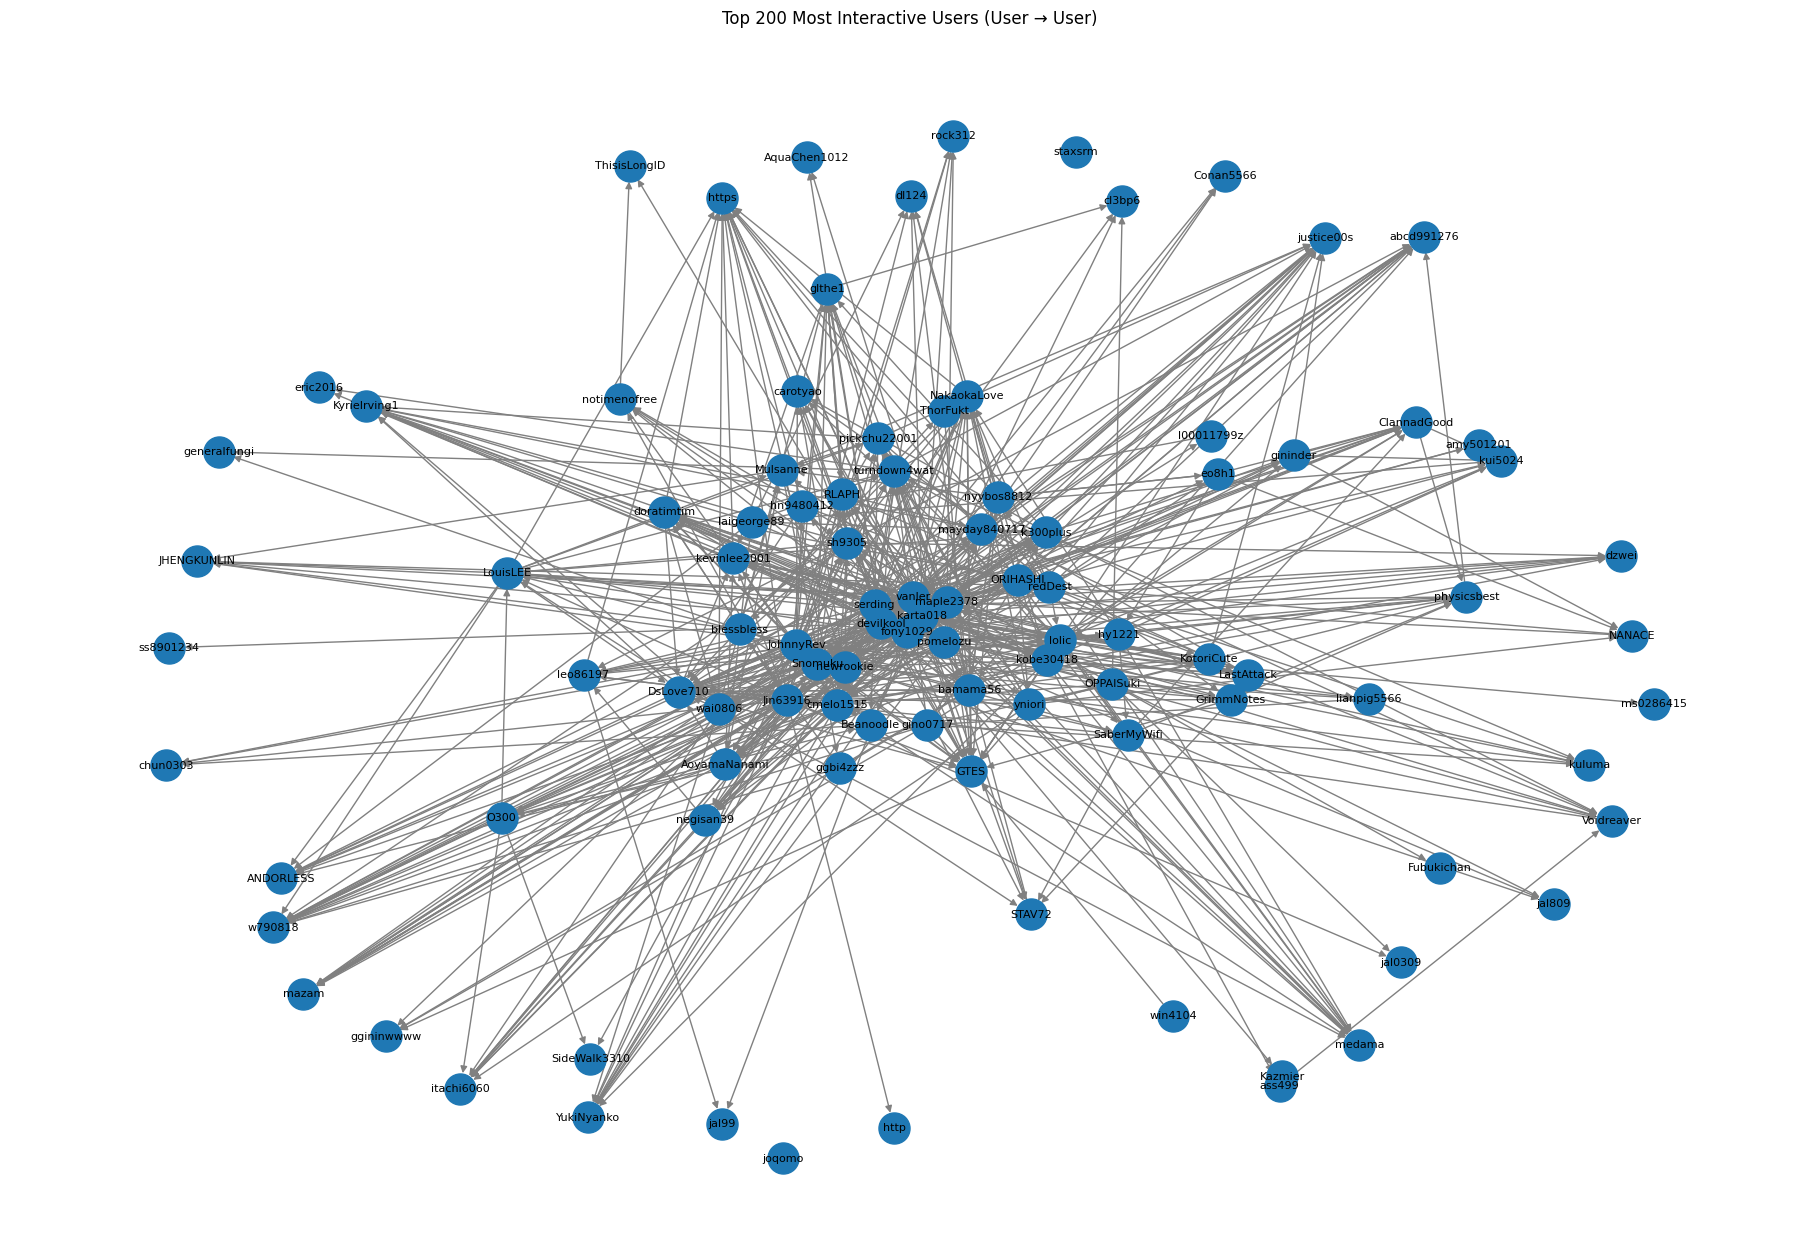

In [ ]:
# 畫圖
plt.figure(figsize=(18, 12))
pos = nx.spring_layout(G_top, k=0.5)
nx.draw(G_top, pos, with_labels=True, node_size=500, font_size=8, edge_color='gray', arrows=True)
plt.title("Top 200 Most Interactive Users (User → User)")
plt.show()